## [RemoteCLIP🛰️: A Vision Language Foundation Model for Remote Sensing](https://arxiv.org/abs/2306.11029)

[Fan Liu (刘凡)](https://multimodality.group/author/%E5%88%98%E5%87%A1/)*
[Delong Chen (陈德龙)](https://chendelong.world/)*
Zhangqingyun Guan (管张青云)
Xiaocong Zhou (周晓聪)
Jiale Zhu (朱佳乐)
[Jun Zhou (周峻)](https://experts.griffith.edu.au/7205-jun-zhou)

\* Equal Contribution

[Github repository](https://github.com/ChenDelong1999/RemoteCLIP/)

[Huggingface model weights](https://huggingface.co/chendelong/RemoteCLIP/tree/main)

-> Run on GPU runtime (top right corner) <-

In [1]:
# @title Install libraries
%%capture
!pip install huggingface_hub open_clip_torch
!git clone https://github.com/ChenDelong1999/RemoteCLIP/

In [2]:
# @title Load packages and download model weights
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

# for model_name in ['RN50'] #, 'ViT-B-32', 'ViT-L-14']: #faster loading
for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RemoteCLIP-RN50.pt:   0%|          | 0.00/408M [00:00<?, ?B/s]

RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.


RemoteCLIP-ViT-B-32.pt:   0%|          | 0.00/605M [00:00<?, ?B/s]

ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.


RemoteCLIP-ViT-L-14.pt:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


In [3]:
# @title Select Model
model_name = 'RN50' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


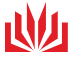

In [10]:
# @title Text caption queries
text_queries = [
    "A busy airport with many aeroplanes.",
    "Satellite view of Hohai university.",
    "griffith logo",
    "A building next to a lake.",
    "logo of chinese forestry academy.",
    "a cute cat",
]
text = tokenizer(text_queries)
image = Image.open("/content/RemoteCLIP/assets/griffith_logo.png").convert('RGB') #convert to rgb allows it to display as png if the jpg is in cmyk
display(image)


In [11]:
# @title Predicted probabilities
image = preprocess(image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.cuda())
    text_features = model.encode_text(text.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

print(f'Predictions of {model_name}:')
for query, prob in zip(text_queries, text_probs):
    print(f"{query:<40} {prob * 100:5.1f}%")

Predictions of RN50:
A busy airport with many aeroplanes.       0.0%
Satellite view of Hohai university.        0.0%
griffith logo                             81.6%
A building next to a lake.                 0.1%
logo of chinese forestry academy.          0.1%
a cute cat                                18.2%


<ipython-input-11-cdf727128d22>:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
